In [ ]:
import torch
import torchaudio
from torch import nn
# plotting
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.optim as optim


In [36]:

# Load the audio file
waveform, sample_rate = torchaudio.load("out.wav")

def get_chunk(start_time):
    # Specify the number of seconds for the window and the start time
    window_seconds = 1
    start_time_secs = start_time

    window_frames = int(sample_rate * window_seconds)
    start_time_frames = int(sample_rate * start_time_secs)

    # Get the label
    label = waveform[:, start_time_frames:start_time_frames + window_frames]

    # Downsample the label to 6kHz
    label = torchaudio.transforms.Resample(sample_rate, 6000)(label)

    # Get the target
    target = waveform[:, start_time_frames + window_frames:start_time_frames + 2 * window_frames]

    # Downsample the target to 6kHz
    target = torchaudio.transforms.Resample(sample_rate, 6000)(target)
    return label, target

In [124]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio

# 1. Import necessary PyTorch libraries and modules
class Seq2SeqAudioModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Seq2SeqAudioModel, self).__init__()
        self.mel_spec = torchaudio.transforms.MelSpectrogram(sample_rate=6000)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.encoder = nn.LSTM(input_dim, hidden_dim)
        self.FCLayer = nn.Linear(hidden_dim, hidden_dim)
        self.rely = nn.Sigmoid()
        self.FC2 = nn.Linear(hidden_dim, hidden_dim)
        self.decoder = nn.LSTM(hidden_dim, output_dim)

    def forward(self, x):
        x, _ = self.encoder(x)
        x, _ = self.decoder(x)
        return x

# 3. Define the model hyperparameters
input_dim = 6000
hidden_dim = 128
output_dim = 6000

# 4. Instantiate the model
model = Seq2SeqAudioModel(input_dim, hidden_dim, output_dim)

# 5. Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 6. Train the model, checkpoint each 100 epochs
num_epochs = 50
checkpoint = 50
LOAD = True
if LOAD:
    model.load_state_dict(torch.load('model.pt'))

for epoch in range(num_epochs):
    optimizer.zero_grad()
    label, target = get_chunk(random.randint(0, 125))
    output = model(label)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if epoch % checkpoint == 0:
        torch.save(model.state_dict(), 'model.pt')

# 7. Save the model
torch.save(model.state_dict(), 'model.pt')

# 8. Load the model
model.load_state_dict(torch.load('model.pt'))


<All keys matched successfully>

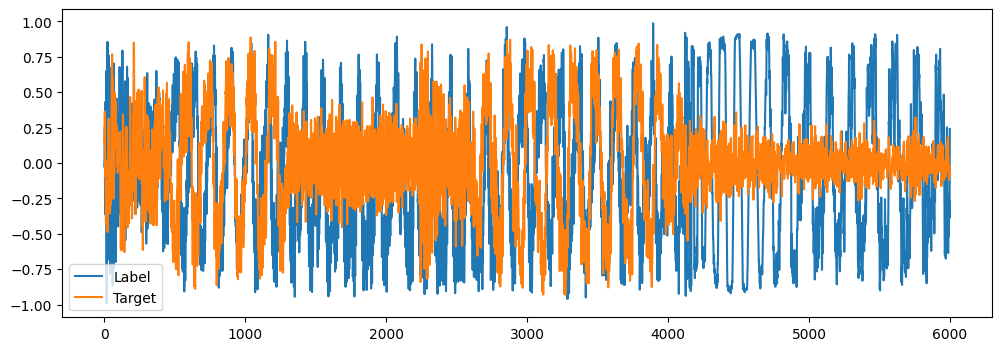

In [125]:

# 9. Inference on new data

# Load the audio file
waveform, sample_rate = torchaudio.load("out.wav")

waveform.shape
# torch.Size([2, 11128320])

window_seconds = 1
window_frames = int(sample_rate * window_seconds)
start_time_secs = 120
start_time_frames = int(sample_rate * start_time_secs)
# truncate the waveform to 1 second
label = waveform[:, start_time_frames:start_time_frames + window_frames]
# downsampling to 6kHz
label = torchaudio.transforms.Resample(sample_rate, 6000)(label)

target = waveform[:, start_time_frames + window_frames:start_time_frames + 2 * window_frames]
target = torchaudio.transforms.Resample(sample_rate, 6000)(target)

def get_output(label, seconds_of_output):
    '''Feed the label to the model to get the output,
    then feed the output back to the model to get the next output
    and so on for the number of seconds specified in seconds_of_output
    '''
    outputs = []
    outputs.append(label)
    outputs.append(model(label))
    for i in range(seconds_of_output):
        outputs.append(model(outputs[-1]))
    return torch.cat(outputs, dim=1)
        
def plot_label_and_target(label, target):
    plt.figure(figsize=(12, 4))
    plt.plot(label[0].numpy(), label='Label')
    plt.plot(target[0].numpy(), label='Target')
    plt.legend()
    plt.show()

plot_label_and_target(label, target)



# Combine the label and output into a single tensor
# Save the output
torchaudio.save('inference.wav', get_output(label, 15), 6000)

    